In [1]:
import pandas as pd
import numpy as np
import sqlite3
import warnings
import warnings
warnings.filterwarnings("ignore")

df=pd.read_csv("athlete_events.csv")
df_=pd.read_csv("noc_regions.csv")

In [2]:
df.head(10)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",NaN
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,NaN
9,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",NaN


In [3]:
df_["new_region"]=[reg if df_["notes"][i] is np.NAN else df_["notes"][i] for i,reg in enumerate(df_["region"])]
df_

,NOC,region,notes,new_region
0,AFG,Afghanistan,NaN,Afghanistan
1,AHO,Curacao,Netherlands Antilles,Netherlands Antilles
2,ALB,Albania,NaN,Albania
3,ALG,Algeria,NaN,Algeria
4,AND,Andorra,NaN,Andorra
...,...,...,...,...
225,YEM,Yemen,NaN,Yemen
226,YMD,Yemen,South Yemen,South Yemen
227,YUG,Serbia,Yugoslavia,Yugoslavia
228,ZAM,Zambia,NaN,Zambia


In [4]:
df=pd.merge(df, df_[["new_region","NOC"]], on="NOC")
df.rename(columns={"new_region":"Region"}, inplace=True)

df["BMI"]=df["Weight"]/(df["Height"]/100)**2

In [5]:
conn=sqlite3.connect("SportsStats.db")
df.to_sql("domain", con=conn, if_exists="replace", index=False)

270767

In [6]:
NOCs=df_[["NOC","new_region"]]
NOCs.rename(columns={"new_region":"Region"}, inplace=True)
NOCs["ID"]= [i+1 for i in range(len(NOCs))]


In [7]:
Athletes=df[["ID","Name","Sex","NOC"]]
Athletes.drop_duplicates(subset="ID", inplace=True)
Athletes=pd.merge(Athletes,NOCs[["NOC","ID"]], on="NOC")
Athletes.rename(columns={"ID_x":"ID","ID_y":"NOC_id"}, inplace=True)
Athletes.drop(columns="NOC", inplace=True)


In [8]:
Competitions=df[["ID","Age","Height","Weight","Games","Year","Season","City","Event"]]
Competitions.rename(columns={"ID":"Athlete_id","Age":"Athlete Age","Height":"Athlete Height","Weight":"Athlete Weight"}, inplace=True)


In [9]:
NOC_qs=df[["NOC","Year","Age","Height","Weight","BMI","Sex"]]
NOC_qs["Male Ratio"]=np.where(NOC_qs["Sex"]=="M",1,0)
NOC_qs["Female Ratio"]=np.where(NOC_qs["Sex"]=="M",0,1)
NOC_qs=pd.merge(NOC_qs, NOCs[["NOC","ID"]], on="NOC")
NOC_qs.drop(columns=["Sex","NOC"], inplace=True)
NOC_qs.rename(columns={"ID":"NOC_id", "Age":"Mean Age","Height":"Mean Height","Weight":"Mean Weight","BMI":"Mean BMI"},inplace=True)
NOC_qs=NOC_qs.groupby(["NOC_id","Year"]).mean()


In [10]:
nom=df[["NOC","Year","Medal"]]
nom=pd.merge(nom, NOCs[["NOC","ID"]], on="NOC")
nom.drop(columns="NOC", inplace=True)
nom.rename(columns={"ID":"NOC_id"},inplace=True)
nom=pd.get_dummies(nom,columns=["Medal"],prefix="",prefix_sep="",dtype=int)
nom=nom.groupby(["NOC_id","Year"]).sum()
nom["Total"]=nom.iloc[:,0]+nom.iloc[:,1]+nom.iloc[:,2]


In [11]:
team=df[["NOC","Team"]]
team=pd.merge(team, NOCs[["NOC","ID"]], on="NOC")
team.drop(columns="NOC", inplace=True)
team.rename(columns={"ID":"NOC_id"},inplace=True)
team.drop_duplicates(subset="Team", inplace=True)
team["ID"]=[i+1 for i in range(len(team))]


In [12]:
# From pandas dataframe to sqlite3
# Run the SQL file (SportsStats.session.sql) to create the SQLite tables before running this cell.

NOCs.to_sql("NOCs", con=conn, if_exists="append", index=False)
Athletes.to_sql("Athletes", con=conn, if_exists="append", index=False)
Competitions.to_sql("Competitions", con=conn, if_exists="append", index=False)
NOC_qs.to_sql("NOC quality stats", con=conn, if_exists="append", index=True)
nom.to_sql("Number of Medals", con=conn, if_exists="append", index=True)
team.to_sql("Teams", con=conn, if_exists="append", index=False)

1179

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270767 entries, 0 to 270766
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      270767 non-null  int64  
 1   Name    270767 non-null  object 
 2   Sex     270767 non-null  object 
 3   Age     261305 non-null  float64
 4   Height  210684 non-null  float64
 5   Weight  207982 non-null  float64
 6   Team    270767 non-null  object 
 7   NOC     270767 non-null  object 
 8   Games   270767 non-null  object 
 9   Year    270767 non-null  int64  
 10  Season  270767 non-null  object 
 11  City    270767 non-null  object 
 12  Sport   270767 non-null  object 
 13  Event   270767 non-null  object 
 14  Medal   39774 non-null   object 
 15  Region  270767 non-null  object 
 16  BMI     206599 non-null  float64
dtypes: float64(4), int64(2), object(11)
memory usage: 35.1+ MB


In [14]:
df.describe()[["Age","Height", "Weight"]]

,Age,Height,Weight
count,261305.000000,210684.000000,207982.000000
mean,25.559783,175.344250,70.709523
std,6.392501,10.519556,14.350094
min,10.000000,127.000000,25.000000
25%,21.000000,168.000000,60.000000
50%,24.000000,175.000000,70.000000
75%,28.000000,183.000000,79.000000
max,97.000000,226.000000,214.000000


In [15]:
qs1=NOC_qs.reset_index()
qs1

,NOC_id,Year,Mean Age,Mean Height,Mean Weight,Mean BMI,Male Ratio,Female Ratio
0,1,1936,24.266667,NaN,NaN,NaN,1.000000,0.000000
1,1,1948,NaN,NaN,NaN,NaN,1.000000,0.000000
2,1,1956,NaN,NaN,NaN,NaN,1.000000,0.000000
3,1,1960,23.312500,170.687500,69.437500,23.841877,1.000000,0.000000
4,1,1964,22.000000,161.000000,64.250000,22.211714,1.000000,0.000000
...,...,...,...,...,...,...,...,...
3284,230,2004,25.071429,177.785714,70.500000,22.191055,0.642857,0.357143
3285,230,2008,26.062500,171.928571,63.714286,21.488787,0.500000,0.500000
3286,230,2012,27.333333,174.444444,65.222222,21.290432,0.444444,0.555556
3287,230,2014,20.000000,182.000000,81.000000,24.453568,1.000000,0.000000


In [16]:
ids=[217,208,112,69] # NOC_id of the USA, Turkey, Saudi Arabia, and Finland respectively.
selected_countries=qs1[qs1["NOC_id"].isin(ids)].dropna()
selected_countries

,NOC_id,Year,Mean Age,Mean Height,Mean Weight,Mean BMI,Male Ratio,Female Ratio
987,69,1906,27.611111,180.857143,92.857143,28.376212,1.000000,0.000000
988,69,1908,24.494624,180.000000,80.840909,24.938687,1.000000,0.000000
989,69,1912,27.120172,176.275862,73.583333,23.425999,0.991416,0.008584
990,69,1920,31.882353,176.129032,73.419355,23.522652,0.992647,0.007353
991,69,1924,29.048951,175.160714,70.669725,22.941421,0.996503,0.003497
...,...,...,...,...,...,...,...,...
3163,217,2008,26.359109,177.668414,74.447090,23.303366,0.520315,0.479685
3164,217,2010,26.017595,174.906158,73.398827,23.804611,0.574780,0.425220
3165,217,2012,26.664731,178.330914,74.692308,23.261321,0.502177,0.497823
3166,217,2014,26.346049,174.989101,72.378747,23.461702,0.569482,0.430518


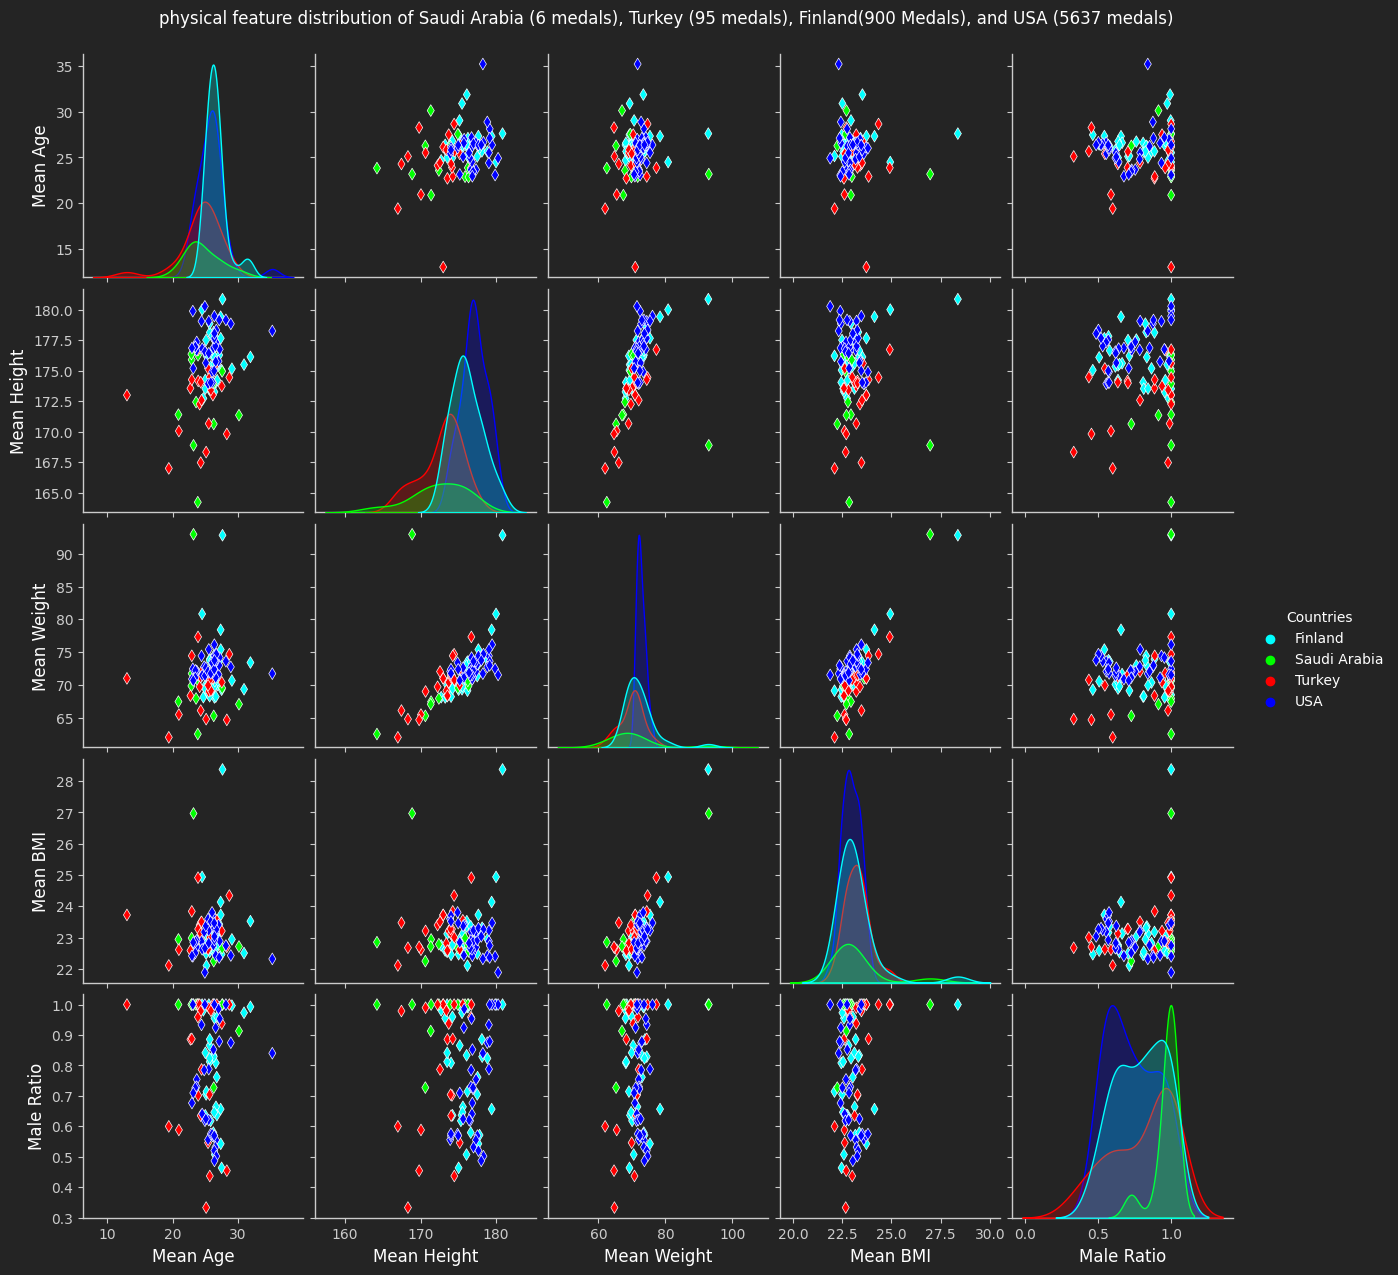

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

labels = ["Finland",'Saudi Arabia','Turkey','USA']

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("CAPstylesheet.matplotlibrc") # stylesheet file that I created for plotting

g=sns.pairplot(selected_countries,hue="NOC_id",markers="d",palette={217:"blue",208:"red",69:"aqua",112:"lime"},vars=["Mean Age","Mean Height","Mean Weight","Mean BMI","Male Ratio"])


g._legend.set_title("Countries")
sns.move_legend(g,"right",bbox_to_anchor=(1.05, 0.5))

for t, l in zip(g._legend.texts, labels):
    t.set_text(l)


g.fig.suptitle("physical feature distribution of Saudi Arabia (6 medals), Turkey (95 medals), Finland(900 Medals), and USA (5637 medals)",y=1.02)
plt.show()

In [18]:
exx=pd.read_sql("""
SELECT 
  Year,
  Region,
  MAX(Total) AS Total_Medals
FROM
  `Number of Medals` nm
JOIN
  NOCs n
ON
  n.ID=nm.NOC_id
GROUP BY
  Year
ORDER BY
  Year DESC;
""",con=conn)
exx

,Year,Region,Total_Medals
0,2016,USA,264
1,2014,Canada,86
2,2012,USA,248
3,2010,USA,97
4,2008,USA,317
5,2006,Canada,69
6,2004,USA,263
7,2002,USA,84
8,2000,USA,242
9,1998,Finland,58


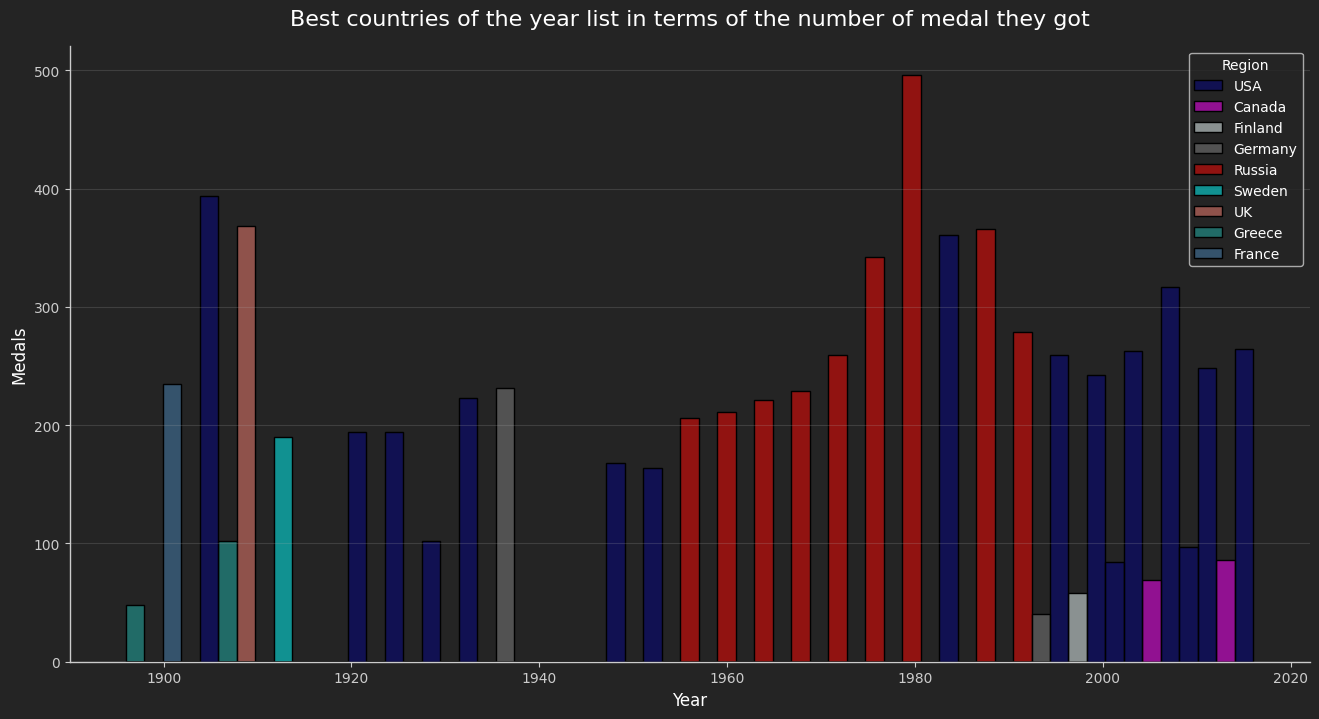

In [19]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("CAPstylesheet.matplotlibrc")

plt.figure(figsize=(16,8))
g=sns.histplot(exx, x="Year",weights="Total_Medals",bins=61,hue="Region", palette={"Russia":(1, 0.01, 0),'UK':"salmon", 'USA':"navy", 'Finland':"azure", 'France':"steelblue", 'Greece':"lightseagreen", 'Sweden':"aqua", 'Germany':"gray", 'Canada':"magenta"})

plt.title("Best countries of the year list in terms of the number of medal they got",y=1.02)
plt.ylabel("Medals")
plt.grid(True,alpha=0.2,axis="y")
plt.show()

In [20]:
exp=pd.read_sql("""
SELECT 
  Region,
  AVG(`Mean Age`) `Mean Age`,
  AVG(`Mean Height`) `Mean Height`,
  AVG(`Mean Weight`) `Mean Weight`,
  AVG(`Mean BMI`) `Mean BMI`,
  AVG(`Male Ratio`) `Male Ratio`,
  AVG(`Female Ratio`) `Female Ratio`
FROM
  `NOC quality stats` nq
JOIN
  NOCs n
ON
  n.ID=nq.NOC_id
GROUP BY
  NOC_id
ORDER BY
  NOC_id ASC
""",conn)
exp

,Region,Mean Age,Mean Height,Mean Weight,Mean BMI,Male Ratio,Female Ratio
0,Afghanistan,23.592321,170.435311,65.883628,22.501021,0.917857,0.082143
1,Netherlands Antilles,28.256704,177.122454,76.935648,24.532117,0.894386,0.105614
2,Albania,24.507720,172.146905,69.225541,22.843816,0.618975,0.381025
3,Algeria,23.953026,173.822785,67.170907,22.120978,0.841003,0.158997
4,Andorra,24.288095,173.672787,70.905553,23.420234,0.728230,0.271770
...,...,...,...,...,...,...,...
224,Yemen,21.440476,168.561224,60.605442,21.369566,0.827381,0.172619
225,South Yemen,23.600000,175.000000,63.333333,22.204082,1.000000,0.000000
226,Yugoslavia,25.198917,179.758800,76.615060,23.539742,0.883931,0.116069
227,Zambia,23.014710,172.842697,65.314904,21.653100,0.830578,0.169422


In [21]:
nqs=pd.read_sql("""
SELECT 
  Year,
  AVG(`Mean Age`) `Mean Age`,
  AVG(`Mean Height`) `Mean Height`,
  AVG(`Mean Weight`) `Mean Weight`,
  AVG(`Mean BMI`) `Mean BMI`,
  AVG(`Male Ratio`) `Male Ratio`,
  AVG(`Female Ratio`) `Female Ratio`
FROM
  `NOC quality stats` nq
JOIN
  NOCs n
ON
  n.ID=nq.NOC_id
GROUP BY
  Year
ORDER BY
  Year ASC
""", conn)
nqs

,Year,Mean Age,Mean Height,Mean Weight,Mean BMI,Male Ratio,Female Ratio
0,1896,23.473932,176.805871,79.293956,25.179981,1.000000,0.000000
1,1900,26.719107,176.825000,72.838562,23.756899,0.987000,0.013000
2,1904,24.709985,175.334565,70.216667,22.340657,0.999038,0.000962
3,1906,25.782998,176.827995,79.930326,25.479213,0.998567,0.001433
4,1908,26.047502,177.444771,74.888204,23.163107,0.996928,0.003072
5,1912,27.288948,176.922821,72.797099,23.224322,0.989599,0.010401
6,1920,28.045099,174.883184,73.120907,23.292236,0.972622,0.027378
7,1924,27.086848,175.109747,71.616494,23.147274,0.962834,0.037166
8,1928,26.827300,174.612011,72.712056,23.392256,0.942538,0.057462
9,1932,32.545128,175.105494,70.510473,22.870957,0.920638,0.079362


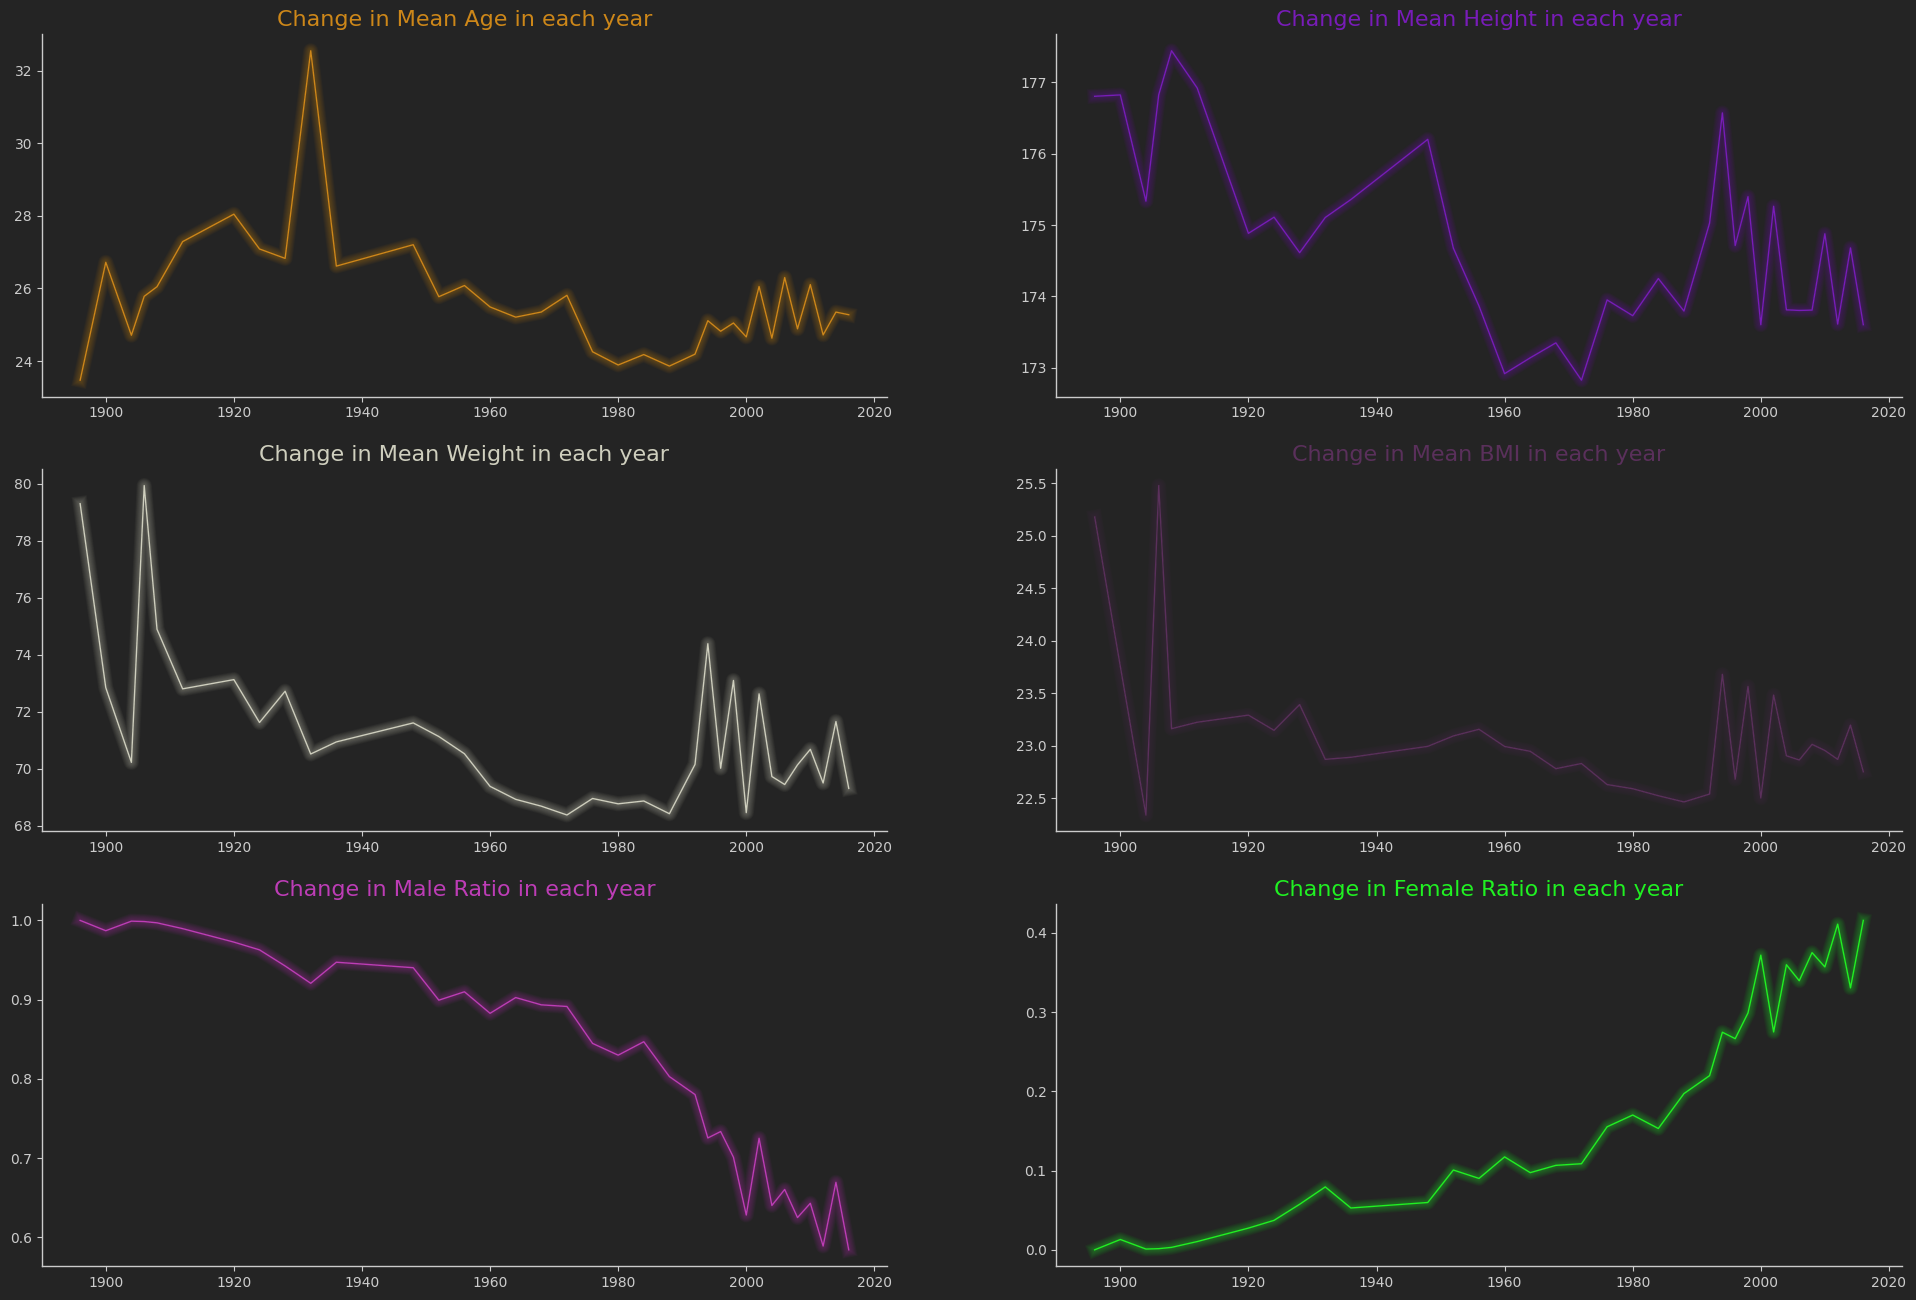

In [22]:
fig, ax = plt.subplots(3,2,figsize=(24,16))
nqs1=nqs.set_index("Year")
for ax1,col in zip(ax.reshape(6,),nqs1.columns):
    color=np.random.sample(3)
    ax1.plot(nqs1.index, nqs1[col], color=color,linewidth=1)
    for g in range(10):
        ax1.plot(nqs1.index, nqs1[col], color=color,alpha=0.04,linewidth=g+2)
    ax1.set_title(f"Change in {col} in each year", color=color)
plt.show()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270767 entries, 0 to 270766
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      270767 non-null  int64  
 1   Name    270767 non-null  object 
 2   Sex     270767 non-null  object 
 3   Age     261305 non-null  float64
 4   Height  210684 non-null  float64
 5   Weight  207982 non-null  float64
 6   Team    270767 non-null  object 
 7   NOC     270767 non-null  object 
 8   Games   270767 non-null  object 
 9   Year    270767 non-null  int64  
 10  Season  270767 non-null  object 
 11  City    270767 non-null  object 
 12  Sport   270767 non-null  object 
 13  Event   270767 non-null  object 
 14  Medal   39774 non-null   object 
 15  Region  270767 non-null  object 
 16  BMI     206599 non-null  float64
dtypes: float64(4), int64(2), object(11)
memory usage: 35.1+ MB


In [24]:
df_model=df.copy()
df_model["Medal"]=np.where(df.iloc[:,14].isnull(),0,1)
df_model=df_model.dropna()
df_model.head(10)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Region,BMI
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,0,China,24.691358
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0,China,20.761246
2,602,Abudoureheman,M,22.0,182.0,75.0,China,CHN,2000 Summer,2000,Summer,Sydney,Boxing,Boxing Men's Middleweight,0,China,22.642193
3,1463,Ai Linuer,M,25.0,160.0,62.0,China,CHN,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Lightweight, Greco-Roman",0,China,24.218750
4,1464,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 200 metres Freestyle,0,China,19.132653
5,1464,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 4 x 200 metres Freestyle Relay,0,China,19.132653
6,3605,An Weijiang,M,22.0,178.0,72.0,China,CHN,2006 Winter,2006,Winter,Torino,Speed Skating,Speed Skating Men's 500 metres,0,China,22.724403
7,3605,An Weijiang,M,22.0,178.0,72.0,China,CHN,2006 Winter,2006,Winter,Torino,Speed Skating,"Speed Skating Men's 1,000 metres",0,China,22.724403
8,3610,An Yulong,M,19.0,173.0,70.0,China,CHN,1998 Winter,1998,Winter,Nagano,Short Track Speed Skating,Short Track Speed Skating Men's 500 metres,1,China,23.388687
9,3610,An Yulong,M,19.0,173.0,70.0,China,CHN,1998 Winter,1998,Winter,Nagano,Short Track Speed Skating,"Short Track Speed Skating Men's 1,000 metres",0,China,23.388687


In [25]:
X=df_model.iloc[:,[2,3,4,5,15]]
y=df_model.iloc[:,14]

"""
        eta-squared
  Interval      Interpretation
(0.00   0.01)     Negligible
(0.01   0.06)       Small
(0.06   0.14)      Medium
(0.14   1.00)       Large

0.00: No influence or no difference 
1.00: Full dependency
"""
import pingouin as png
for col in df_model.columns[[3,4,5,16]]: # Age	Height	Weight  BMI
    res=png.anova(df_model,col,"Medal") # one-way anova which means np2 = n2 (partial eta_squared = eta-squared)
    print(res,"\n\n")


  Source  ddof1   ddof2           F         p-unc       np2
0  Medal      1  205909  162.087072  4.089615e-37  0.000787 


  Source  ddof1   ddof2            F  p-unc       np2
0  Medal      1  205909  1648.897238    0.0  0.007944 


  Source  ddof1   ddof2            F  p-unc       np2
0  Medal      1  205909  1623.875518    0.0  0.007825 


  Source  ddof1   ddof2           F          p-unc       np2
0  Medal      1  205909  602.346751  8.034096e-133  0.002917 




In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.compose import ColumnTransformer

X=X.values
y=y.values

X_train,X_,y_train,y_=train_test_split(X,y,train_size=0.6,random_state=0)
X_cv,X_test,y_cv,y_test=train_test_split(X_,y_,random_state=0,test_size=0.5)

scaler=StandardScaler()
transformer=ColumnTransformer([("norm1", scaler, [1,2,3]),])

X_train_scaled=transformer.fit_transform(X_train)
X_cv_scaled=transformer.transform(X_cv)
X_test_scaled=transformer.transform(X_test)

In [27]:
xgbc = XGBClassifier(max_depth=10).fit(X_train_scaled,y_train)

y_pred=xgbc.predict_proba(X_train_scaled)
auc=roc_auc_score(y_train,y_pred[:, 1])
print("Accuracy score of the train data:", xgbc.score(X_test_scaled,y_test),"\n", "Area under the curve score of the train data:", auc,"\n")

y_pred=xgbc.predict(X_train_scaled)
matrix=confusion_matrix(y_train,y_pred)
print("Confusion Matrix of the train data:","\n", matrix,"\n")

y_pred=xgbc.predict_proba(X_cv_scaled)
auc=roc_auc_score(y_cv,y_pred[:, 1])
print("Accuracy score of the cv data:", xgbc.score(X_test_scaled,y_test),"\n", "Area under the curve score of the cv data:", auc,"\n")

y_pred=xgbc.predict(X_cv_scaled)
matrix=confusion_matrix(y_cv,y_pred)
print("Confusion Matrix of the cv data:", "\n",matrix,"\n")

y_pred=xgbc.predict_proba(X_test_scaled)
auc=roc_auc_score(y_test,y_pred[:, 1])
print("Accuracy score of the test data:", xgbc.score(X_test_scaled,y_test),"\n", "Area under the curve score of the test data:", auc,"\n")

y_pred=xgbc.predict(X_test_scaled)
matrix=confusion_matrix(y_test,y_pred)
print("Confusion Matrix of the test data:", "\n",matrix,"\n")

# Since the eta-squared is less than 0.01 (negligible effect size), our machine couldn't produce accurate estimations.

Accuracy score of the train data: 0.8533375421897385 
 Area under the curve score of the train data: 0.7320617160555889 

Confusion Matrix of the train data: 
 [[105275     83]
 [ 17495    693]] 

Accuracy score of the cv data: 0.8533375421897385 
 Area under the curve score of the cv data: 0.5926827094624696 

Confusion Matrix of the cv data: 
 [[35027   146]
 [ 5935    74]] 

Accuracy score of the test data: 0.8533375421897385 
 Area under the curve score of the test data: 0.5900682233687856 

Confusion Matrix of the test data: 
 [[35070   138]
 [ 5902    73]] 

